In [1]:
import numpy
import math
import torch
from collections import Counter 
import matplotlib.pyplot as plt
import torch.nn.functional as F


In [2]:
words = open('names.txt', 'r').read().splitlines()
len(words)

32033

In [3]:
chars = sorted(list(set(''.join(words))))
s2i = {s:i + 1 for i, s in enumerate(chars)}  # create str to index of all letters
s2i['.'] = 0 # ending and starting character is '.'



i2s = {i:s for s, i in s2i.items()}  # reverse the dictionary from index to string

In [4]:
search_word = 'tyler'

for place, name in enumerate(words):
    if search_word in name:
        print(f'tyler is on line {place}')

tyler is on line 1364
tyler is on line 18147


In [5]:
s = set(words)
duplicates = [item for item in words[:50] if words.count(item) > 1 and item in s]

In [6]:
bigrams = {}

# for w in words:
#     chs = ["<S>"] + list(w) + ["<E>"]
#     for ch1, ch2 in zip(chs, chs[1:]):
#         b = (ch1, ch2)
#         bigrams[b] = bigrams.get(b, 0) + 1


In [7]:
# sorted(bigrams.items(), key = lambda kv: -kv[1])

In [8]:
bigram_counter = Counter(bigrams)

mc = bigram_counter.most_common(5)
mc

[]

In [9]:

N = torch.zeros((27,27), dtype=torch.int32) # create array 

for w in words:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = s2i[ch1]
        ix2 = s2i[ch2]
        N[ix1, ix2] += 1


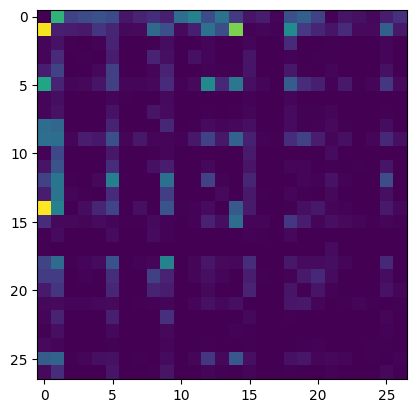

In [10]:
plt.imshow(N)


In [ ]:
plt.figure(figsize = (16,16))
print("fin")
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = i2s[i] + i2s[j]
        plt.text(j, i, chstr, ha='center', va='top', color='gray')
        plt.text(j, i, N[i, j].item(), ha='center', va='bottom', color='gray')
        plt.savefig("BigramsCount")
plt.axis('off');
plt.imshow(N)
print("fin")
plt.savefig("BigramsCount")

fin


In [ ]:
print(N[0,:].sum())


In [12]:
p = N[0].float()
p = p / p.sum()
# this is getting probabilties of the first row

In [15]:
g = torch.Generator().manual_seed(214748364)
p = torch.rand(3, generator = g) # creates a list of 3 probabilities
p = p / p.sum() # normalize 
p
# this generated 3 random numbers, and converted them to probabilities

tensor([0.2008, 0.3866, 0.4126])

In [14]:
torch.multinomial(p, num_samples=20, replacement=True, generator=g) #using the probabilites list 'p' this creates 20 samples using them

tensor([0, 2, 2, 2, 1, 2, 2, 1, 2, 0, 0, 0, 1, 2, 1, 1, 1, 2, 0, 0])

In [15]:
P = (N+1) / N.sum(dim=1, keepdim=True) # dim = 1 sums across rows whereas dim = 0 sums each column
P = torch.round(P * 1000) / 1000 # keepdim=True makes sure that rows and not columns get normalized

#P[0].sum() # if this is == 1 it means the row is normalized

In [16]:
g = torch.Generator().manual_seed(214748364)


for i in range(20):
    ix = 0
    out = []
    while True:
 
        p = P[ix] # pulls out the row
        
        # V1. p = N[ix].float() # get the entire row in floating point
        # V1 p = p / p.sum() # divide row by sum to get weights
        
        # p = torch.ones(27) / 27 this would create an equal distribution which is the same as an untrained model
        
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() # creates one sample using the probability matrix
        out.append(i2s[ix]) # create a list of samples and wait under the terminator

        if ix == 0:
            break
   # print(''.join(out))

In [23]:
log_liklihood = 0
n = 0
for w in words[:3]:
    chs = '.' + w + '.'
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = s2i[ch1]
        ix2 = s2i[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_liklihood += logprob
        print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')
        n += 1
        
pll = -log_liklihood
avg = pll / n
print(avg)

NameError: name 'P' is not defined

In [4]:
xs, ys = [], []

for w in words:
    chs = "." + w + "."
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = s2i[ch1]
        ix2 = s2i[ch2]
        xs.append(ix1)
        ys.append(ix2)
        
xs = torch.tensor(xs)
ys = torch.tensor(ys)


In [5]:

xenc = F.one_hot(xs, num_classes=27).float()
print(xenc.shape)

torch.Size([228146, 27])


In [6]:
g2 = torch.Generator().manual_seed(214748364)
W = torch.randn((27, 27), generator=g2, requires_grad=True)

In [27]:
# (16 x 27) @ (27 x 27) => (16 x 27) 

In [ ]:
loss = -probs[xs, ys].log().mean()
loss

In [ ]:
# BACKWARD PASS
W.grad = None
loss.backward()

In [ ]:
W.data += -0.1 * W.grad

In [25]:
for i in range(5):
    
    
    
    # FORWARD PASS
    xenc = F.one_hot(xs, num_classes=27).float()

    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True) # normalize rows
    num = xs.nelement()
    loss = -probs[torch.arange(num), ys].log().mean() # + .02 * (W**2).mean()
    
    # BACKWARD PASS
    
    
    W.grad = None
    loss.backward()
    
    W.data += -10 * W.grad
    
    if i == 25:
        print(loss)
    


print("finished")

torch.Size([228146])
torch.Size([228146])
torch.Size([228146])
torch.Size([228146])
torch.Size([228146])
finished


In [20]:
print(loss.item())
print(probs[4, 4].item())

2.5400636196136475
0.03038601391017437


In [26]:
for i in range(5):
    
    out = []
    ix = 0
    
    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W
        counts = logits.exp()
        p = counts / counts.sum(1, keepdim=True)
        ix = torch.multinomial(p, num_samples=1, replacement=True,generator=g).item()

        out.append(i2s[ix])

        if ix == 0:
            break
            
    print(''.join(out))

ribinhbgi.
zuia.
aien.
js.
tarqqoelayavin.
